,content,description,title,category,price,availability,rating,url
0,It's hard to imagine a world without A Light i...,It's hard to imagine a world without A Light i...,A Light in the Attic,Poetry,51.77,In stock,Three,http://books.toscrape.com/catalogue/a-light-in...
1,"""Erotic and absorbing...Written with starling ...","""Erotic and absorbing...Written with starling ...",Tipping the Velvet,Historical Fiction,53.74,In stock,One,http://books.toscrape.com/catalogue/tipping-th...
2,"Dans une France assez proche de la nÃ´tre, un ...","Dans une France assez proche de la nÃ´tre, un ...",Soumission,Fiction,50.10,In stock,One,http://books.toscrape.com/catalogue/soumission...
3,"WICKED above her hipbone, GIRL across her hear...","WICKED above her hipbone, GIRL across her hear...",Sharp Objects,Mystery,47.82,In stock,Four,http://books.toscrape.com/catalogue/sharp-obje...
4,From a renowned historian comes a groundbreaki...,From a renowned historian comes a groundbreaki...,Sapiens: A Brief History of Humankind,History,54.23,In stock,Five,http://books.toscrape.com/catalogue/sapiens-a-...
5,Patient Twenty-nine.A monster roams the halls ...,Patient Twenty-nine.A monster roams the halls ...,The Requiem Red,Young Adult,22.65,In stock,One,http://books.toscrape.com/catalogue/the-requie...
6,Drawing on his extensive experience evaluating...,Drawing on his extensive experience evaluating...,The Dirty Little Secrets of Getting Your Dream...,Business,33.34,In stock,Four,http://books.toscrape.com/catalogue/the-dirty-...
7,"""If you have a heart, if you have a soul, Kare...","""If you have a heart, if you have a soul, Kare...",The Coming Woman: A Novel Based on the Life of...,Default,17.93,In stock,Three,http://books.toscrape.com/catalogue/the-coming...
8,For readers of Laura Hillenbrand's Seabiscuit ...,For readers of Laura Hillenbrand's Seabiscuit ...,The Boys in the Boat: Nine Americans and Their...,Default,22.60,In stock,Four,http://books.toscrape.com/catalogue/the-boys-i...
9,"Praise for Aracelis Girmay:""[Girmay's] every l...","Praise for Aracelis Girmay:""[Girmay's] every l...",The Black Maria,Poetry,52.15,In stock,One,http://books.toscrape.com/catalogue/the-black-...


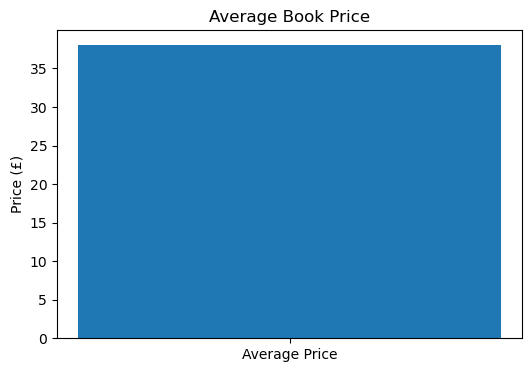

In [11]:
#1. import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urljoin
import re

#2. Base URL
url = "http://books.toscrape.com/"

#3. Download and parse the main page 
response = requests.get(url)
response.raise_for_status()  # raise an error if the request failed
html_string = response.text
document = BeautifulSoup(html_string, "html.parser")
 
# Find all book cards on the page
book_articles = document.find_all("article", attrs={"class": "product_pod"})

#4. Prepare empty lists for data 
contents = []        
descriptions = []    
titles = []
categories = []
prices = []
availabilities = []
ratings = []
urls = []

#5. Loop over all books in the first page and collect information 
for book in book_articles:
    # Title 
    title = book.find("h3").find("a")["title"]

    # Price 
    price_raw = book.find("p", attrs={"class": "price_color"}).text.strip()

    # Availability 
    availability = book.find("p", attrs={"class": "instock availability"}).text.strip()

    # Rating 
    rating_tag = book.find("p", attrs={"class": "star-rating"})
    rating = None
    if rating_tag:
        classes = rating_tag.get("class", [])
        if len(classes) > 1:
            rating = classes[1]  

    # Build full URL for each book
    relative_url = book.find("h3").find("a")["href"]
    full_url = urljoin(url, relative_url)

    # Request the individual book page 
    response_book = requests.get(full_url)
    response_book.raise_for_status()
    html_book = response_book.text
    book_document = BeautifulSoup(html_book, "html.parser")

    #  Description from the book page 
    description_header = book_document.find("div", attrs={"id": "product_description"})
    if description_header:
        description_tag = description_header.find_next_sibling("p")
        if description_tag:
            description = description_tag.get_text(strip=True)
        else:
            description = None
    else:
        description = None

    # If the description is missing, mark it as "na"
    if not description:
        description = "na"

    # Category from the breadcrumb 
    breadcrumb = book_document.find("ul", attrs={"class": "breadcrumb"})
    category = None
    if breadcrumb:
        li_tags = breadcrumb.find_all("li")
        if len(li_tags) >= 3:
            category = li_tags[2].get_text(strip=True)

    # Clean the price using regex to remove spaces and special characters
    cleaned_price_str = re.sub(r"[^0-9.]", "", price_raw)  
    try:
        cleaned_price = float(cleaned_price_str)
    except ValueError:
        cleaned_price = None  # in case something goes wrong

    # Content column for the corpus 
    content = description

    # Append everything to lists 
    contents.append(content)
    descriptions.append(description)
    titles.append(title)
    categories.append(category)
    prices.append(cleaned_price)
    availabilities.append(availability)
    ratings.append(rating)
    urls.append(full_url)

#6. Build DataFrame 
data = {
    "content": contents,          # main text used as corpus
    "description": descriptions,  # explicit description column
    "title": titles,
    "category": categories,
    "price": prices,              # numeric prices
    "availability": availabilities,
    "rating": ratings,
    "url": urls
}

df = pd.DataFrame(data)

#7. Save to CSV with UTF-8 encoding
df.to_csv("books_corpus.csv", index=False, encoding="utf-8")

display(df)

#8 import matplotlib for visualization
import matplotlib.pyplot as plt

# Calculate the average price of all books in the dataset
avg_price = df["price"].mean()

# Create a bar chart with a single bar showing the average price
plt.figure(figsize=(6, 4))
plt.bar(["Average Price"], [avg_price])

# Add title and axis label for clarity
plt.title("Average Book Price")
plt.ylabel("Price (£)")

# Display the plot
plt.show()

